### Leemos y limpiamos los datos

In [1]:
import pandas as pd 
import os
import numpy as np
import re
from nltk.corpus import stopwords
import nltk
try:
    stopwords.words('spanish')
except LookupError:
    nltk.download('stopwords')

ruta = "../data"
archivo = os.path.join(ruta, "Rest-Mex_2025_train.csv") 

with open(archivo, 'r', encoding='utf-8', errors='replace') as f:
    Data = pd.read_csv(f)

#Arreglamos la mala lectura de los acentos debido a la codificación
def arregla_mojibake(texto):
    try:
        return texto.encode('latin1').decode('utf-8')
    except:
        return texto  # Si falla la conversión, deja el texto igual

Data['Title'] = Data['Title'].fillna('').apply(arregla_mojibake)
Data['Review'] = Data['Review'].fillna('').apply(arregla_mojibake)

stopwords_es = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑüÜ\s]', '', texto)
    palabras = texto.split()
    palabras = [palabra for palabra in palabras if palabra not in stopwords_es]
    return ' '.join(palabras).strip()

Data['Texto_Limpio'] = (Data['Title'].fillna('') + ' ' + Data['Review'].fillna('')).apply(limpiar_texto)

### Representaciones de texto

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer # type: ignore

def Representacion_TF_IDF(dataframe):
    textos = dataframe['Texto_Limpio'].fillna("").values
    
    vectorizer = TfidfVectorizer(
        max_features=2500,
        ngram_range=(1, 2),
        token_pattern=r'(?u)\b[^\d\W]+\b'
    )
    
    X_tfidf = vectorizer.fit_transform(textos)
    
    print(f"Matriz TF-IDF generada con forma: {X_tfidf.shape}")
    return X_tfidf, vectorizer

# Generamos la representación TF-IDF de los textos
X_tfidf, vectorizer = Representacion_TF_IDF(Data)

Matriz TF-IDF generada con forma: (208051, 2500)


In [4]:
from gensim.models import Word2Vec
def Representacion_word2vec(dataframe, vector_size=100, window=5, min_count=5, sg=1, epochs=10):
    textos = dataframe['Texto_Limpio'].fillna("").apply(str.split).values

    # Entrenar el modelo Word2Vec
    model = Word2Vec(
        sentences=textos, 
        vector_size=vector_size, 
        window=window, 
        min_count=min_count, 
        sg=sg,  # 1=skip-gram, 0=CBOW
        workers=8,
        epochs=epochs
    )

    # Crear el vector promedio para cada documento
    def obtener_vector_promedio(tokens):
        vectores = [model.wv[word] for word in tokens if word in model.wv]
        return np.mean(vectores, axis=0) if vectores else np.zeros(model.vector_size)

    vectores_documento = np.array([obtener_vector_promedio(tokens) for tokens in textos])
    return vectores_documento, model

X_word2vec, modelow2v =  Representacion_word2vec(Data, vector_size=100, window=3, min_count=5, sg=1, epochs=10)

In [6]:
!pip uninstall -y torch torchvision torchaudio


Found existing installation: torch 2.6.0
Uninstalling torch-2.6.0:
  Successfully uninstalled torch-2.6.0


You can safely remove it manually.


In [7]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB 8.4 MB/s eta 0:04:53
     ---------------------------------------- 0.0/2.4 GB 8.8 MB/s eta 0:04:38
     ---------------------------------------- 0.0/2.4 GB 8.4 MB/s eta 0:04:52
     ---------------------------------------- 0.0/2.4 GB 8.0 MB/s eta 0:05:06
     ---------------------------------------- 0.0/2.4 GB 8.0 MB/s eta 0:05:07
     ---------------------------------------- 0.0/2.4 GB 7.9 MB/s eta 0:05:09
     ---------------------------------------- 0.0/2.4 GB 7.9 MB/s eta 0:05:09
     ---------------------------------------- 0.0/2.4 GB 7.9 MB/s eta 0:05:10
     ---------------------------------------- 0.0/2.4 GB 7.9 MB/s eta 0:05:10
     ---------------------------------------- 0.0/2.4 GB 7.8 MB/s eta 0:05:14
     ---------------------------------------- 0.0/2.4 GB 7.8 MB/s eta 0:05:11
     -------

In [2]:
import torch

print("¿CUDA disponible?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("→ GPU detectada:", torch.cuda.get_device_name(0))
    print("→ Versión de CUDA:", torch.version.cuda)
    print("→ Versión de PyTorch:", torch.__version__)
else:
    print("⚠️ CUDA no está disponible. Revisa drivers o compatibilidad.")


¿CUDA disponible? True
→ GPU detectada: NVIDIA GeForce RTX 3050 6GB Laptop GPU
→ Versión de CUDA: 12.1
→ Versión de PyTorch: 2.5.1+cu121


In [4]:
from sentence_transformers import SentenceTransformer
import torch
import numpy as np

def Representacion_BERT_optimizado(dataframe, batch_size=32):
    """
    Obtiene representaciones BERT de los textos limpios usando GPU si está disponible.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Usando dispositivo: {device}")

    model = SentenceTransformer('distiluse-base-multilingual-cased-v1', device=device)
    textos = dataframe['Texto_Limpio'].fillna("").tolist()

    # Codificar en lotes
    embeddings = model.encode(
        textos, 
        batch_size=batch_size, 
        show_progress_bar=True, 
        device=device
    )
    
    print(f"Matriz de embeddings BERT generada con forma: {np.array(embeddings).shape}")
    return np.array(embeddings), model
X_bert, modelo= Representacion_BERT_optimizado(Data, batch_size=32)

Usando dispositivo: cuda


Batches:   0%|          | 0/6502 [00:00<?, ?it/s]

Matriz de embeddings BERT generada con forma: (208051, 512)


In [2]:
from gensim.models import FastText
def Representacion_fasttext(dataframe, vector_size=100, window=5, min_count=5, sg=1, epochs=10):
    """
    Entrena FastText y obtiene el vector promedio por documento.
    - sg=1 usa skip-gram (mejor semántica)
    - min_count=5 ignora palabras raras
    """
    textos = dataframe['Texto_Limpio'].fillna("").apply(str.split).values

    # Entrenar el modelo FastText
    model = FastText(
        sentences=textos,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=sg,  # 1=skip-gram, 0=CBOW
        workers=8,
        epochs=epochs
    )

    # Crear el vector promedio para cada documento
    def obtener_vector_promedio(tokens):
        vectores = [model.wv[word] for word in tokens if word in model.wv]
        return np.mean(vectores, axis=0) if vectores else np.zeros(model.vector_size)

    vectores_documento = np.array([obtener_vector_promedio(tokens) for tokens in textos])

    print(f"Matriz FastText generada con forma: {vectores_documento.shape}")
    return vectores_documento, model

X_fasttext, modelo_fasttext = Representacion_fasttext(Data, vector_size=100, window=2, min_count=3, sg=1, epochs=10)

Matriz FastText generada con forma: (208051, 100)


### Herramientas estadisticas para revisar el desbalance en Polarity

In [4]:
import pandas as pd
polarity_counts = pd.Series(Data['Polarity']).value_counts(normalize=True) * 100
print(polarity_counts * Data.shape[0] / 100)


Polarity
5.0    136561.0
4.0     45034.0
3.0     15519.0
2.0      5496.0
1.0      5441.0
Name: proportion, dtype: float64


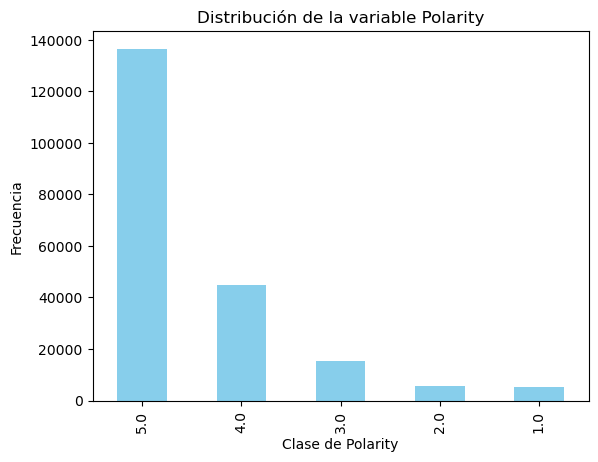

In [3]:
import matplotlib.pyplot as plt

Data['Polarity'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribución de la variable Polarity')
plt.xlabel('Clase de Polarity')
plt.ylabel('Frecuencia')
plt.show()


### Regresion logistica con pesos balanceados

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

def modelo_logistica_balanceado(X, y, test_size=0.2, random_state=42):
    """
    Entrena un modelo de regresión logística multiclase balanceando clases.
    """
    # División estratificada para mantener el desbalance en test y train
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    log_reg = LogisticRegression(
        max_iter=1000,
        solver='lbfgs',  # <-- cambio clave aquí
        class_weight='balanced',
        multi_class='multinomial',  # opcional, pero recomendado para multiclase
    random_state=random_state)

    # Entrenar el modelo
    log_reg.fit(X_train, y_train)

    # Predicciones
    y_pred = log_reg.predict(X_test)

    # Evaluación
    print("=== Reporte de Clasificación ===\n")
    print(classification_report(y_test, y_pred, digits=4))
    print("=== Matriz de Confusión ===\n")
    print(confusion_matrix(y_test, y_pred))
    
    return log_reg

#modelo_logistica_balanceado(X_tfidf, Data['Polarity'])
#modelo_logistica_balanceado(X_word2vec, Data['Polarity'])
#modelo_logistica_balanceado(X_fasttext, Data['Polarity'])
modelo_logistica_balanceado(X_bert, Data['Polarity'])


c:\Users\uzgre\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Reporte de Clasificación ===

              precision    recall  f1-score   support

         1.0     0.4296    0.6562    0.5193      1088
         2.0     0.1971    0.4258    0.2695      1099
         3.0     0.2832    0.4288    0.3411      3104
         4.0     0.3829    0.4815    0.4266      9007
         5.0     0.8751    0.6904    0.7719     27313

    accuracy                         0.6178     41611
   macro avg     0.4336    0.5366    0.4657     41611
weighted avg     0.6949    0.6178    0.6451     41611

=== Matriz de Confusión ===

[[  714   283    60    14    17]
 [  320   468   223    60    28]
 [  228   659  1331   663   223]
 [  147   433  1667  4337  2423]
 [  253   531  1419  6252 18858]]


LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=42)

In [7]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

def modelo_logistica(X, y, test_size=0.2, random_state=42):
    """
    Entrena un modelo de regresión logística multiclase.
    """
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Crear el modelo de regresión logística
    log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=random_state)
    

    # Usar OneVsRestClassifier para clasificación multiclase
    modelo = OneVsRestClassifier(log_reg)

    # Ajustar el modelo
    modelo.fit(X_train, y_train)  # Aquí cambias X_tfidf por X_train

    # Hacer predicciones
    y_pred = modelo.predict(X_test)

    # Evaluar el desempeño
    print("Clasificación:\n", classification_report(y_test, y_pred))
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
    
    return modelo
modelo_logistica(X_bert, Data['Polarity'])

Clasificación:
               precision    recall  f1-score   support

         1.0       0.58      0.55      0.57      1063
         2.0       0.41      0.04      0.08      1106
         3.0       0.46      0.21      0.29      3059
         4.0       0.46      0.23      0.31      9272
         5.0       0.75      0.95      0.84     27111

    accuracy                           0.70     41611
   macro avg       0.53      0.40      0.41     41611
weighted avg       0.65      0.70      0.65     41611

Matriz de confusión:
 [[  585    36   131    80   231]
 [  261    47   261   199   338]
 [  108    22   634   959  1336]
 [   28     7   261  2126  6850]
 [   18     4    89  1280 25720]]


OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000,
                                                 random_state=42))

### Oversampling SMOTE + Logistic

In [4]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

def modelo_smote_logistica(X, y, test_size=0.2, random_state=42):
    # División estratificada
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Aplicar SMOTE solo en el entrenamiento
    smote = SMOTE(random_state=random_state)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    print(f"Original: {y_train.value_counts()}")
    print(f"Resampleado: {y_train_res.value_counts()}")

    # Modelo sin class_weight porque SMOTE ya balanceó
    log_reg = LogisticRegression(
        max_iter=2000,
        solver='saga',
        multi_class='multinomial',
        random_state=random_state
    )

    log_reg.fit(X_train_res, y_train_res)
    y_pred = log_reg.predict(X_test)

    print("=== Reporte de Clasificación con SMOTE ===\n")
    print(classification_report(y_test, y_pred, digits=4))
    print("=== Matriz de Confusión ===\n")
    print(confusion_matrix(y_test, y_pred))
    
    return log_reg

# Llamada
modelo_smote_logistica(X_tfidf, Data['Polarity'])


Original: Polarity
5.0    109248
4.0     36027
3.0     12415
2.0      4397
1.0      4353
Name: count, dtype: int64
Resampleado: Polarity
5.0    109248
4.0    109248
3.0    109248
1.0    109248
2.0    109248
Name: count, dtype: int64


c:\Users\uzgre\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Reporte de Clasificación con SMOTE ===

              precision    recall  f1-score   support

         1.0     0.4004    0.6075    0.4827      1088
         2.0     0.2111    0.4013    0.2767      1099
         3.0     0.3130    0.4523    0.3700      3104
         4.0     0.4091    0.4946    0.4478      9007
         5.0     0.8818    0.7262    0.7965     27313

    accuracy                         0.6440     41611
   macro avg     0.4431    0.5364    0.4747     41611
weighted avg     0.7067    0.6440    0.6672     41611

=== Matriz de Confusión ===

[[  661   284    95    27    21]
 [  315   441   270    55    18]
 [  246   612  1404   663   179]
 [  173   343  1594  4455  2442]
 [  256   409  1123  5690 19835]]


LogisticRegression(max_iter=2000, multi_class='multinomial', random_state=42,
                   solver='saga')

### Subsamplig + Logistic

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

def modelo_submuestreo(X, y, test_size=0.2, random_state=42):
    """
    Entrena un modelo de regresión logística con submuestreo para balancear las clases.
    """
    # Submuestreo para balancear las clases
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=test_size, random_state=random_state)
    
    # Crear el modelo de regresión logística
    log_reg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=random_state)

    # Ajustar el modelo
    log_reg.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = log_reg.predict(X_test)

    # Evaluar el desempeño
    print("Clasificación:\n", classification_report(y_test, y_pred))
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
    
    return log_reg

# Aplicar el modelo con submuestreo
modelo_submuestreo(X_tfidf, Data['Polarity'])


Clasificación:
               precision    recall  f1-score   support

         1.0       0.60      0.66      0.63      1079
         2.0       0.45      0.37      0.40      1115
         3.0       0.46      0.41      0.43      1132
         4.0       0.47      0.51      0.49      1076
         5.0       0.62      0.71      0.66      1039

    accuracy                           0.53      5441
   macro avg       0.52      0.53      0.52      5441
weighted avg       0.52      0.53      0.52      5441

Matriz de confusión:
 [[711 230  84  30  24]
 [349 408 247  64  47]
 [ 96 216 459 270  91]
 [ 26  35 180 546 289]
 [ 10  11  37 246 735]]


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [33]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/150.0 MB 7.1 MB/s eta 0:00:21
    --------------------------------------- 2.1/150.0 MB 5.6 MB/s eta 0:00:27
    --------------------------------------- 2.9/150.0 MB 4.9 MB/s eta 0:00:30
    --------------------------------------- 3.4/150.0 MB 4.3 MB/s eta 0:00:35
   - -------------------------------------- 3.9/150.0 MB 4.0 MB/s eta 0:00:37
   - -------------------------------------- 4.2/150.0 MB 3.6 MB/s eta 0:00:41
   - -------------------------------------- 4.5/150.0 MB 3.3 MB/s eta 0:00:44
   - -------------------------------------- 5.0/150.0 MB 3.1 MB/s eta 0:00:48
   - -------------------------------------- 5.2/150.0 MB 3.0 MB/s eta 0:00:48
   - -------------------------------------- 5.5/150.0 MB 2.9 MB/s eta 0:00:51
   - -------------------------------------- 5.8/150.0 MB 2.6 MB/s eta 0:00:57
   - -------------------------------------- 5.8/150.0 MB 2.6 MB/s eta 0

In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

def modelo_xgboost(X, y, test_size=0.2, random_state=42):
    """
    Entrena un modelo XGBoost para clasificación multiclase.
    """
    # Convertir las clases de 'Polarity' a valores de 0 a 4
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Crear el modelo XGBoost
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
    
    # Ajustar el modelo
    xgb_model.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = xgb_model.predict(X_test)

    # Evaluar el desempeño
    print("Clasificación:\n", classification_report(y_test, y_pred))
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
    
    return xgb_model


# Llamada a la función
modelo_xgboost(X_tfidf, Data['Polarity'])


c:\Users\uzgre\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:34:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Clasificación:
               precision    recall  f1-score   support

           0       0.63      0.46      0.53      1063
           1       0.41      0.14      0.21      1106
           2       0.49      0.20      0.29      3059
           3       0.49      0.22      0.31      9272
           4       0.74      0.96      0.84     27111

    accuracy                           0.70     41611
   macro avg       0.55      0.40      0.43     41611
weighted avg       0.66      0.70      0.65     41611

Matriz de confusión:
 [[  494    96   101    69   303]
 [  177   155   226   179   369]
 [   73    98   616   835  1437]
 [   27    22   234  2051  6938]
 [   13    10    76  1040 25972]]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [6]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

def modelo_xgboost_smote(X, y, test_size=0.2, random_state=42):
    """
    Entrena un modelo XGBoost para clasificación multiclase utilizando SMOTE para balancear las clases.
    """
    # Convertir las clases de 'Polarity' a valores de 0 a 4
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Aplicar SMOTE al conjunto de entrenamiento
    smote = SMOTE(random_state=random_state)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Crear el modelo XGBoost
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
    
    # Ajustar el modelo con los datos balanceados
    xgb_model.fit(X_train_res, y_train_res)

    # Hacer predicciones en el conjunto de prueba
    y_pred = xgb_model.predict(X_test)

    # Evaluar el desempeño
    print("Clasificación:\n", classification_report(y_test, y_pred))
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
    
    return xgb_model


# Llamada a la función con SMOTE
modelo_xgboost_smote(X_tfidf, Data['Polarity'])


c:\Users\uzgre\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:39:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Clasificación:
               precision    recall  f1-score   support

           0       0.53      0.52      0.53      1063
           1       0.31      0.26      0.28      1106
           2       0.39      0.28      0.33      3059
           3       0.44      0.26      0.33      9272
           4       0.75      0.89      0.82     27111

    accuracy                           0.68     41611
   macro avg       0.49      0.44      0.46     41611
weighted avg       0.64      0.68      0.65     41611

Matriz de confusión:
 [[  557   152    63    18   273]
 [  247   283   170    65   341]
 [  128   273   858   480  1320]
 [   59   129   750  2416  5918]
 [   55    82   379  2453 24142]]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)